<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multomodal_EfficientnetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3571         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1652         39  1.0          

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# ------------------------------
# PARAMETERS
# ------------------------------
IMG_SIZE = 224
DATASET_PATH = "OvarianCancer"
CSV_PATH = "Ovarian_patient_data.csv"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {cls: i for i, cls in enumerate(classes)}


In [ ]:
# ------------------------------
# LOAD IMAGES
# ------------------------------
X_images, y_labels = [], []

for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        X_images.append(img)
        y_labels.append(class_mapping[cls])

X_images = np.array(X_images)
y_labels = np.array(y_labels)
y_onehot = tf.keras.utils.to_categorical(y_labels)


In [ ]:
# ------------------------------
# LOAD TABULAR DATA
# ------------------------------
df = pd.read_csv('/content/Ovarian_patient_data.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
features = ["age", "ca125", "cancerstage", "bmi"]
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)


In [ ]:
# ------------------------------
# TRAIN TEST SPLIT
# ------------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_onehot, test_size=0.2, stratify=y_labels, random_state=42
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# ------------------------------
# CLASS WEIGHTS
# ------------------------------
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# ------------------------------
# IMAGE DATA AUGMENTATION
# ------------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate


In [ ]:
# ------------------------------
# MODEL DEFINITION
# ------------------------------
# EfficientNetB0 Backbone
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

# Tabular Model
tab_input = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = Dense(64, activation="relu")(tab_input)
y = Dropout(0.3)(y)
y = Dense(32, activation="relu")(y)

# Combine
combined = Concatenate()([x, y])
z = Dense(64, activation="relu")(combined)
output = Dense(len(classes), activation="softmax")(z)

model = Model(inputs=[base_model.input, tab_input], outputs=output)

# ------------------------------
# COMPILE
# ------------------------------
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=Adam(1e-4), loss=loss_fn, metrics=["accuracy"])

# ------------------------------
# CALLBACKS
# ------------------------------
checkpoint = ModelCheckpoint("efficientnet_multimodal_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)


In [ ]:
# ------------------------------
# TRAIN
# ------------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=20,
    batch_size=8,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, lr_reduce],
    verbose=1
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2299 - loss: 2.2709
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 717ms/step - accuracy: 0.2297 - loss: 2.2679 - val_accuracy: 0.4200 - val_loss: 1.4683 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.3449 - loss: 1.7598
Epoch 2: val_accuracy improved from 0.42000 to 0.57000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 678ms/step - accuracy: 0.3454 - loss: 1.7579 - val_accuracy: 0.5700 - val_loss: 1.3319 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4317 - loss: 1.5625
Epoch 3: val_accuracy improved from 0.57000 to 0.59000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 691ms/step - accuracy: 0.4315 - loss: 1.5626 - val_accuracy: 0.5900 - val_loss: 1.2167 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5007 - loss: 1.4132
Epoch 4: val_accuracy improved from 0.59000 to 0.66000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 601ms/step - accuracy: 0.5008 - loss: 1.4135 - val_accuracy: 0.6600 - val_loss: 1.1233 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5747 - loss: 1.3164
Epoch 5: val_accuracy improved from 0.66000 to 0.71000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 660ms/step - accuracy: 0.5744 - loss: 1.3164 - val_accuracy: 0.7100 - val_loss: 1.0518 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5755 - loss: 1.2710
Epoch 6: val_accuracy improved from 0.71000 to 0.72000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 684ms/step - accuracy: 0.5755 - loss: 1.2714 - val_accuracy: 0.7200 - val_loss: 0.9919 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5951 - loss: 1.2040
Epoch 7: val_accuracy improved from 0.72000 to 0.77000, saving model to efficientnet_multimodal_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 573ms/step - accuracy: 0.5949 - loss: 1.2045 - val_accuracy: 0.7700 - val_loss: 0.9520 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5918 - loss: 1.2012
Epoch 8: val_accuracy did not improve from 0.77000
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 671ms/step - accuracy: 0.5920 - loss: 1.2010 - val_accuracy: 0.7700 - val_loss: 0.9219 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6731 - loss: 1.1262
Epoch 9: val_accuracy did not improve from 0.77000
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 679ms/step - accuracy: 0.6729 - loss: 1.1259 - val_accuracy: 0.7700 - val_loss: 0.8951 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6715 - loss: 1.0277
Epoch 10: val_accuracy did not improve from 0.77000

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 658ms/step - accuracy: 0.6719 - loss: 1.

50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 686ms/step - accuracy: 0.6788 - loss: 1.0598 - val_accuracy: 0.7800 - val_loss: 0.8696 - learning_rate: 5.0000e-05
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6445 - loss: 1.1342
Epoch 13: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 652ms/step - accuracy: 0.6453 - loss: 1.1328 - val_accuracy: 0.7800 - val_loss: 0.8600 - learning_rate: 5.0000e-05
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6869 - loss: 1.0836
Epoch 14: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.6869 - loss: 1.0828 - val_accuracy: 0.7800 - val_loss: 0.8568 - learning_rate: 5.0000e-05
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6888 - loss: 1.0016
Epoch 15: val_accuracy did not improve from 0.78000

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.6889 - loss

In [ ]:
# ------------------------------
# LOAD BEST MODEL & EVALUATE
# ------------------------------
model.load_weights("efficientnet_multimodal_best.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Test Accuracy: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7974 - loss: 0.8571

✅ Best Test Accuracy: 78.00%


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# ------------------------------
# UNFREEZE THE TOP LAYERS OF EFFICIENTNETB0
# ------------------------------
# Unfreeze the last few layers
for layer in base_model.layers[-10:]:  # Fine-tune the last 10 layers
    layer.trainable = True

# ------------------------------
# COMPILE WITH A LOWER LEARNING RATE
# ------------------------------
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss=loss_fn,
              metrics=["accuracy"])

# ------------------------------
# DATA AUGMENTATION (Enhanced)
# ------------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ------------------------------
# CALLBACKS (with early stopping to avoid overfitting)
# ------------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# ------------------------------
# TRAINING WITH FINE-TUNING
# ------------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=30,  # Increase epochs for fine-tuning
    batch_size=8,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, lr_reduce, early_stop],
    verbose=1
)

# ------------------------------
# LOAD BEST MODEL & EVALUATE
# ------------------------------
model.load_weights("efficientnet_multimodal_best.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Fine-Tuned Test Accuracy: {acc*100:.2f}%")


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5777 - loss: 1.1705
Epoch 1: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - accuracy: 0.5783 - loss: 1.1706 - val_accuracy: 0.7600 - val_loss: 0.8768 - learning_rate: 1.0000e-05
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.5907 - loss: 1.1426
Epoch 2: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - accuracy: 0.5914 - loss: 1.1425 - val_accuracy: 0.7400 - val_loss: 0.8948 - learning_rate: 1.0000e-05
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6162 - loss: 1.1729
Epoch 3: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 735ms/step - accuracy: 0.6167 - loss: 1.1725 - val_accuracy: 0.7400 - val_loss: 0.9029 - learning_rate: 1.0000e-05
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6432 - loss: 1.1159
Epoch 4: val_accuracy did not improve from 0.78000

Epoch 4: Redu

In [ ]:
model.save("efficientnetb0_multimodal_final.h5")


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


<Figure size 800x600 with 0 Axes>

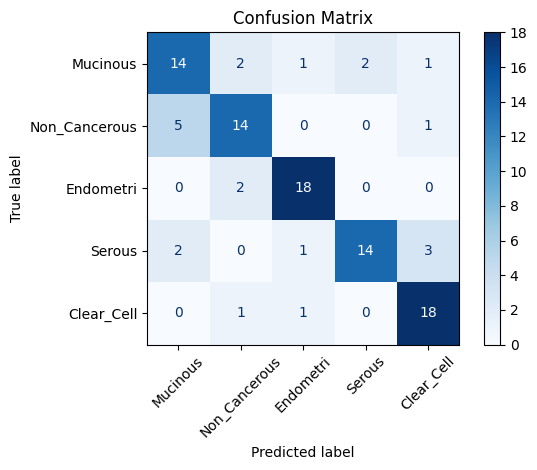

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred_probs = model.predict([X_test_img, X_test_tab])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
